In [20]:
using HDF5, AeroAcoustics, PyPlot

The AeroAcoustics.jl package is structured around the struct `Environment`, that takes all neccessary variables associated with an acoustic image as input. 

We will use the measurement data in the `data` folder. 
These files are cross-spectral matrices (csm), a frequency domain representation of the measurement.

Open the hdf5 file from the /data directory and assemble the data to a Complex array.

In [21]:
csm_file = joinpath(pwd(),"data","NACA63018_u0_80mps_aoa_0_clean.h5")
csm_ref = h5open(csm_file, "r") do file
    read(file, "CsmData/csmReal")+im*read(file, "CsmData/csmImag")
end;

Get the associated frequencies, and microphone array geometry:

In [22]:
fc = h5read(csm_file, "CsmData")["binCenterFrequenciesHz"]
micgeom = h5read(csm_file, "CsmData")["arrayGeom"];

We are now ready populate the `Environment` struct. 
The measurement distance `z0`, the microphone geometry `micgeom`, and the csm `CSM` are required variables.

First, the csm is constructed as a FreqArray, which holds the array and associated frequency bins:

In [23]:
CSM = FreqArray(csm_ref,fc);

The distance between source and receiver plane is

In [24]:
z0 = 2.3 

2.3

Let's also define the expected source position (TE noise) and a region of integration:

In [9]:
src_pos = (0.05,0.05)
dxdy = (0.5,0.8)
int_region = AeroAcoustics.point_to_region(src_pos,dxdy)

4-element Vector{Float64}:
 -0.2
  0.3
 -0.35000000000000003
  0.45

The `Environment` is defined:

In [25]:
E = Environment(
    z0 = z0,
    micgeom = micgeom,
    CSM = CSM,
    dr = true,
    flim = (800,4000),
    Nx = 61,
    Ny = 41,
    xlim = (-1.0,1.5),
    ylim = (-1.0,1.0)
);

Now, we need to assign steering vectors (transfer functions) between the grid points defined in the environment `E` and the microphone locations in `micgeom`, this is done in a simple manner:

In [26]:
steeringvectors!(E)

where the "!" mutates the environment `E` and stores the steering vectors associated with the Environment. 

If a flow field is defined in the environment, the correct steering vectors will automatically be calculated, or we can define our own function `my_custom_steeringvectors!(E)` (wink, wink)...

Next, we calculate the beamforming image:

In [27]:
b = beamforming(E);

the output is a `FreqArray` of size `E.Nx*E.Ny` times the number of frequency bins within the limits defined in `E`. To plot the acoustic image, reshape the beamforming result, select a frequency bin and convert to dB:

In [28]:
fc = 2000
f_idx =  argmin(abs.(E.fn .- fc)) # finds index in E.fn that is closest to fc
bdB = SPL.(reshape(b[:,f_idx],E.Nx,E.Ny)) # conversion to dB.
maxdb = maximum(filter(!isnan,bdB)) # find peak dB value
dynrange = 12 # set beamforming dynamic range

12

Now plot:

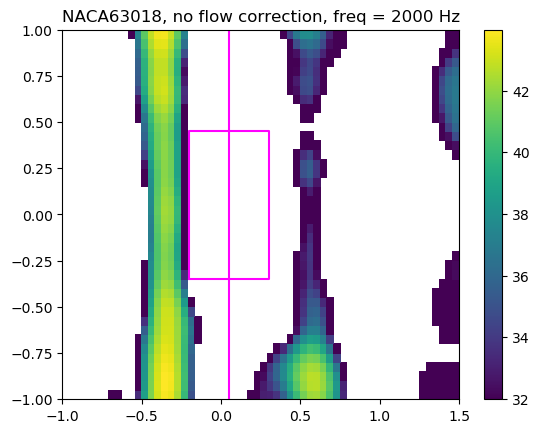

In [29]:
clf()
pcolormesh(E.rx,E.ry,bdB',vmax=maxdb,vmin=maxdb-dynrange)
PyPlot.plot([0.05,0.05],[-1,1],alpha=1,color="magenta") # TE position
x1,x2,y1,y2 = int_region
PyPlot.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], alpha=1,color="magenta") # integration region square
colorbar() 
title("NACA63018, no flow correction, freq = $(fc) Hz")
gcf()

Now, let's instead define a new Environment *with* a shear layer correction:

In [30]:
E_flow = Environment(
    z0 = z0,
    micgeom = micgeom,
    CSM = CSM,
    dr = true,
    flim = (800,4000),
    Nx = 61,
    Ny = 41,
    xlim = (-1.0,1.5),
    ylim = (-1.0,1.0),
    # adding flow-info:
    shear = true,
    ampcorr = false,
    Ma = 0.24, # info from measurement
    h = 1.5, # distance from source to shear-layer plane
);

Now, we need to assign steering vectors to the environment with a flow correction.

In [31]:
steeringvectors!(E_flow)

Next, we calculate the new (flow-corrected) beamforming image:

In [32]:
b_flow = beamforming(E_flow)
fc = 2000
f_idx =  argmin(abs.(E_flow.fn .- fc)) # finds index in E.fn that is closest to fc
bdB_flow = SPL.(reshape(b_flow[:,f_idx],E_flow.Nx,E_flow.Ny)) # convertion to dB.
maxdb = maximum(filter(!isnan,bdB_flow)) # find peak dB value
dynrange = 12 # set beamforming dynamic range

12

And plot again:

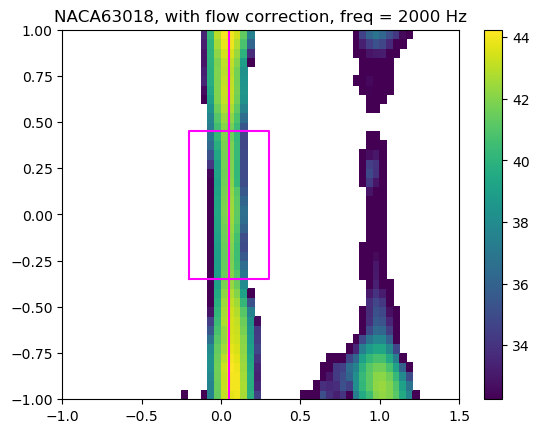

In [33]:
clf()
pcolormesh(E_flow.rx,E_flow.ry,bdB_flow',vmax=maxdb,vmin=maxdb-dynrange)
PyPlot.plot([0.05,0.05],[-1,1],alpha=1,color="magenta")
x1,x2,y1,y2 = int_region
PyPlot.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], alpha=1,color="magenta")
colorbar()
title("NACA63018, with flow correction, freq = $(fc) Hz")
gcf()

Finally, let's get the source integration result and plot

In [35]:
SPI_srcint = SPI(b,E,dxdy,int_region)
SPI_srcint_flow = SPI(b_flow,E_flow,dxdy,int_region);

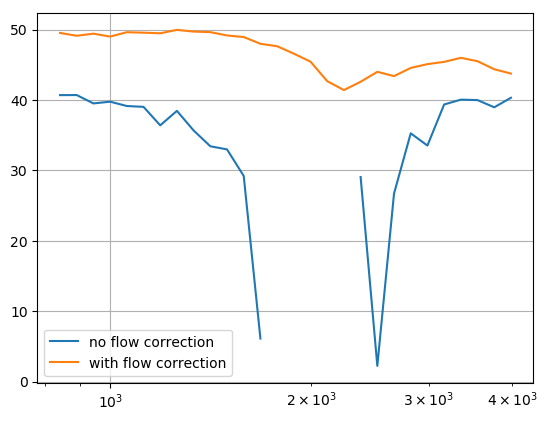

In [36]:
clf()
semilogx(SPI_srcint.fc,SPL.(SPI_srcint),label="no flow correction")
semilogx(SPI_srcint_flow.fc,SPL.(SPI_srcint_flow),label="with flow correction")
legend()
grid(true)
gcf()

The no-flow correction case is obviously much lower than the flow-corrected case, because the noise source was located outside the source integration region!